# Codon Frequencies
This notebook parses FASTQ files and calculates the frequency of codons at site 734 in Zika Virus NS5 protein.

FASTQ files for each cell population are specified in `samplesheet.csv`

## Notebook setup
Imports

In [1]:
import gzip
import os.path
import numpy as np
import pandas as pd
import plotnine as p9
import regex
from Bio import SeqIO

# print imports and versions
# copied from https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook
print('\n'.join(f'{m.__name__}=={m.__version__}' \
                for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.19.1
pandas==1.3.2
plotnine==0.8.0
regex==2.5.83


Input data

In [2]:
samplesheet = 'tmp.csv'
reference_file = 'ns5.fasta'
codons_file = 'codons.csv.gz'

Analysis parameters

In [3]:
codon_start = 2203  # nposition in reference for first codon nt
upstream_length = 15  # length of sequence before codon to search for
downstream_length = 15  # length of sequence after codon to search for
mismatches = 1  # number of mismatches allowed (per upstream/downstream sequence)
nucleotides_allowed = 'ACGT'

Notebook aesthetics

In [4]:
p9.theme_set(p9.theme_classic())
CBPALETTE_RICH = ['#648FFF', '#FFB000', '#DC267F', '#785EF0', '#FE6100']

## Load data
Load samples

In [5]:
samples = pd.read_csv(samplesheet)
display(samples)

,sample_name,infected,IFN,read,fastq_file
0,Mut_NS5_Sample,True,None,R1,/shared/ngs/illumina/bloom_lab/210917_M04866_0...
1,Mut_NS5_Sample,True,None,R2,/shared/ngs/illumina/bloom_lab/210917_M04866_0...
2,Mut_Rnd1_mCherry_neg,True,False,R1,/shared/ngs/illumina/bloom_lab/210917_M04866_0...
3,Mut_Rnd1_mCherry_neg,True,False,R2,/shared/ngs/illumina/bloom_lab/210917_M04866_0...


Load reference sequence

In [6]:
reference = SeqIO.read(reference_file, 'fasta')
print(reference.id)
print(reference.seq)

NS5
CGTGGAGGTGGGACGGGAGAGACTCTGGGAGAGAAGTGGAAAGCTCGTCTGAATCAGATGTCGGCCCTGGAGTTCTACTCTTATAAAAAGTCAGGTATCACTGAAGTGTGTAGAGAGGAGGCTCGCCGTGCCCTCAAGGATGGAGTGGCCACAGGAGGACATGCCGTATCCCGGGGAAGTGCAAAGCTCAGATGGTTGGTGGAGAGAGGATATCTGCAGCCCTATGGGAAGGTTGTTGACCTCGGATGTGGCAGAGGGGGCTGGAGCTATTATGCCGCCACCATCCGCAAAGTGCAGGAGGTGAGAGGATACACAAAGGGAGGTCCCGGTCATGAAGAACCCATGCTGGTGCAAAGCTATGGGTGGAACATAGTTCGTCTCAAGAGTGGAGTGGACGTCTTCCACATGGCGGCTGAGCCGTGTGACACTCTGCTGTGTGACATAGGTGAGTCATCATCTAGTCCTGAAGTGGAAGAGACACGAACACTCAGAGTGCTCTCTATGGTGGGGGACTGGCTTGAAAAAAGACCAGGGGCCTTCTGTATAAAGGTGCTGTGCCCATACACCAGCACTATGATGGAAACCATGGAGCGACTGCAACGTAGGCATGGGGGAGGATTAGTCAGAGTGCCATTGTCTCGCAACTCCACACATGAGATGTACTGGGTCTCTGGGGCAAAGAGCAACATCATAAAAAGTGTGTCCACCACAAGTCAGCTCCTCCTGGGACGCATGGATGGCCCCAGGAGGCCAGTGAAATATGAGGAGGATGTGAACCTCGGCTCGGGTACACGAGCTGTGGCAAGCTGTGCTGAGGCTCCTAACATGAAAATCATCGGCAGGCGCATTGAGAGAATCCGCAATGAACATGCAGAAACATGGTTTCTTGATGAAAACCACCCATACAGGACATGGGCCTACCATGGGAGCTACGAAGCCCCCACGCAAGGATCAGCGTCTTCCCTCGTGAACGGGGTTGTTAGACTCCTGTCAAAG

## Parse codon sequence
Parse sequences if codons file is not already given in root directory.

Open codons file if present

In [7]:
if os.path.isfile(codons_file):
    print(f'Loading results from {codons_file}')
    results = pd.read_csv(codons_file)
    print('Done.')
else:
    pass

Extract sequences upstream and downstream of codon

In [8]:
if os.path.isfile(codons_file):
    pass
else:
    # feature positions in reference sequence
    codon_end = codon_start + 2
    upstream_start = codon_start - upstream_length
    upstream_end = codon_start - 1
    downstream_start = codon_end + 1
    downstream_end = codon_end + downstream_length

    # feature values
    # python indexing is not inclusive of first coordinate, so
    # all start positions are adjusted by -1
    codon_reference = reference.seq[(codon_start-1):codon_end]
    upstream = reference.seq[(upstream_start-1):upstream_end]
    downstream = reference.seq[(downstream_start-1):downstream_end]

    # print
    print(f'The codon starts at position {codon_start} and '
          f'ends at position {codon_end} in the reference.')
    print(f'The WT codon sequence in the reference is: {codon_reference}\n')
    print(f'The upstream search sequence starts at position {upstream_start} '
          f'and ends at position {upstream_end} in the reference.')
    print(f'The upstream search sequence is: {upstream}\n')
    print(f'The downstream search sequence starts at position {downstream_start} '
          f'and ends at position {downstream_end} in the reference.')
    print(f'The downstream search sequence is: {downstream}')

The codon starts at position 2203 and ends at position 2205 in the reference.
The WT codon sequence in the reference is: GAT

The upstream search sequence starts at position 2188 and ends at position 2202 in the reference.
The upstream search sequence is: CCTTGCCGCCACCAA

The downstream search sequence starts at position 2206 and ends at position 2220 in the reference.
The downstream search sequence is: GAACTGATTGGCCGA


Bring in experiment info

In [65]:
results_annotated = pd.merge(
    left=samples[['sample_name', 'infected', 'IFN']].drop_duplicates(),
    right=codon_counts[['sample_name', 'codon', 'frequency']],
    on='sample_name',
    how='right',
    validate='one_to_many'
)

display(results_annotated)

,sample_name,infected,IFN,codon,frequency
0,WT_NS5_Sample,True,None,GAT,9.731316e-01
1,WT_NS5_Sample,True,None,AAT,6.500315e-03
2,WT_NS5_Sample,True,None,GAC,4.953228e-03
3,WT_NS5_Sample,True,None,GGT,3.695821e-03
4,WT_NS5_Sample,True,None,TAT,1.414662e-03
5,WT_NS5_Sample,True,None,GAG,1.040942e-03
6,WT_NS5_Sample,True,None,CAT,9.951022e-04
7,WT_NS5_Sample,True,None,TGT,9.078795e-04
8,WT_NS5_Sample,True,None,ATT,7.283409e-04
9,WT_NS5_Sample,True,None,GCT,7.207010e-04


Build regex search

In [9]:
if os.path.isfile(codons_file):
    pass
else:
    pattern = (f'(?:{upstream}){{e<={mismatches}}}' +  # match upstream
                  f'([{nucleotides_allowed}]{{3}})' +  # match and capture codon
                  f'(?:{downstream}){{e<={mismatches}}}')  # match downstream
    print(f'The search pattern for will be:\n{pattern}')

The search pattern for will be:
(?:CCTTGCCGCCACCAA){e<=1}([ACGT]{3})(?:GAACTGATTGGCCGA){e<=1}


Iterate through reads and store codons:

In [10]:
if os.path.isfile(codons_file):
    pass
else:
    results = list()

    for index, sample in samples.iterrows():
        assert sample['read'] in ['R1', 'R2'], "unrecognized read"
        with gzip.open(sample['fastq_file'], mode='rt') as handle:
            print(f'Parsing data for {sample["sample_name"]} {sample["read"]}')
            print(f'File is:  {sample["fastq_file"]}')
            seqs = SeqIO.parse(handle, 'fastq')
            for sequence in seqs:
                if(sample['read'] == 'R1'):
                    search_seq = sequence.seq
                elif(sample['read'] == 'R2'):
                    search_seq = sequence.seq.reverse_complement()
                result = regex.search(pattern, str(search_seq))
                if result == None:
                    match = 'failed_parse'
                    codon = 'failed_parse'
                else:
                    match = result.group(0)
                    codon = result.group(1)
                results.append((sample['sample_name'],
                                sample['read'],
                                sequence.id,
                                match,
                                codon))
            print('\n')

    results = pd.DataFrame(results)
    results.columns = ['sample_name','read','read_id','match_string','codon']
    print(f'Saving results to {codons_file}')
    results.to_csv(codons_file)

Parsing data for Mut_NS5_Sample R1
File is:  /shared/ngs/illumina/bloom_lab/210917_M04866_0509_000000000-JW58W/Data/Intensities/BaseCalls/Mut-NS5-Sample_S2_L001_R1_001.fastq.gz


Parsing data for Mut_NS5_Sample R2
File is:  /shared/ngs/illumina/bloom_lab/210917_M04866_0509_000000000-JW58W/Data/Intensities/BaseCalls/Mut-NS5-Sample_S2_L001_R2_001.fastq.gz


Parsing data for Mut_Rnd1_mCherry_neg R1
File is:  /shared/ngs/illumina/bloom_lab/210917_M04866_0509_000000000-JW58W/Data/Intensities/BaseCalls/Mut-Rnd1-mCherry-neg_S3_L001_R1_001.fastq.gz


Parsing data for Mut_Rnd1_mCherry_neg R2
File is:  /shared/ngs/illumina/bloom_lab/210917_M04866_0509_000000000-JW58W/Data/Intensities/BaseCalls/Mut-Rnd1-mCherry-neg_S3_L001_R2_001.fastq.gz


Saving results to codons.csv.gz


In [11]:
display(results)

,sample_name,read,read_id,match_string,codon
0,Mut_NS5_Sample,R1,M04866:509:000000000-JW58W:1:1101:17676:1836,CCTTGCCGCCACCACTGTGAACTGATTGGCCGA,TGT
1,Mut_NS5_Sample,R1,M04866:509:000000000-JW58W:1:1101:17487:1897,CCCTTGCCGCCACCAACTTGGACTGATTGGCCGA,CTT
2,Mut_NS5_Sample,R1,M04866:509:000000000-JW58W:1:1101:17997:1916,CCCTTGCCGCCACCAATTTGAACTGATTGGCCGA,TTT
3,Mut_NS5_Sample,R1,M04866:509:000000000-JW58W:1:1101:17798:1919,CCCTTGCCGCCACCAATTGGAACTGATTGGCCGA,TTG
4,Mut_NS5_Sample,R1,M04866:509:000000000-JW58W:1:1101:17039:1925,CCCTTGCCGCCACCAATTTGAACTGATTGGCCGA,TTT
...,...,...,...,...,...
7130593,Mut_Rnd1_mCherry_neg,R2,M04866:509:000000000-JW58W:1:2114:17221:29234,CCCTTGCCGCCACCAATGTGAACTGATTGGCCGA,TGT
7130594,Mut_Rnd1_mCherry_neg,R2,M04866:509:000000000-JW58W:1:2114:16387:29238,CCCTTGCCGCCACCAATGTGAACTGATTGGCCGA,TGT
7130595,Mut_Rnd1_mCherry_neg,R2,M04866:509:000000000-JW58W:1:2114:16463:29249,CCCTTGCCGCCACCAATGTGAACTGATTGGCCGA,TGT
7130596,Mut_Rnd1_mCherry_neg,R2,M04866:509:000000000-JW58W:1:2114:14290:29250,CCCTTGCCGCCACCAATGTGAACTGATTGGCCGA,TGT


## Plot quality control

Number of reads with codon successfully parsed per sample:

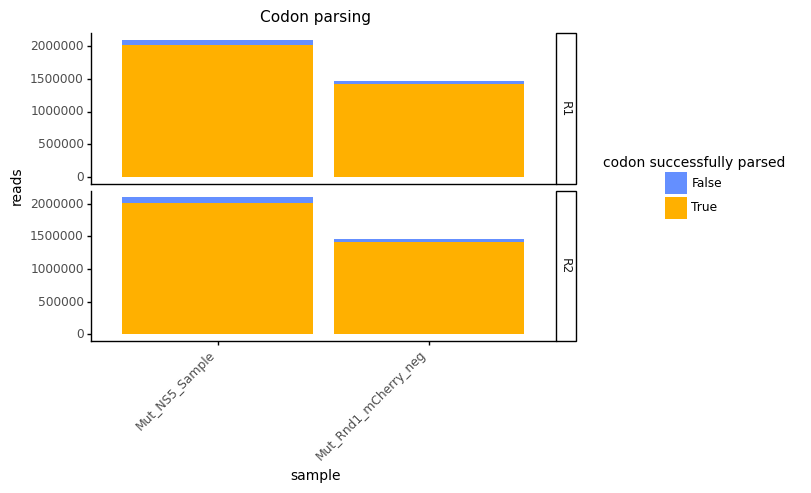

<ggplot: (8728390326269)>

In [12]:
parsing_qc = (p9.ggplot(results) +
              p9.aes(x='sample_name',
                     fill='codon != "failed_parse"') +
              p9.geom_bar(stat='count') +
              p9.facet_grid('read~') +
              p9.ggtitle('Codon parsing') +
              p9.labs(x='sample',
                      y='reads',
                      fill='codon successfully parsed') +
              p9.theme(figure_size=(6, 4),
                       plot_title=p9.element_text(size=11),
                       axis_title=p9.element_text(size=10),
                       axis_text_x=p9.element_text(rotation=45, hjust=1),
                       legend_position='right',
                       legend_title=p9.element_text(size=10),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE_RICH[0:])
              )

display(parsing_qc)

Pair reads by read_id

In [13]:
results_pairs = (
    results
    .pivot(index=['sample_name','read_id'], columns='read', values='codon')
    .reset_index())

#  Check for missing mate
results_pairs['missing_mate'] = (
    results_pairs['R1'].isnull() | results_pairs['R2'].isnull()
)

#  Check for mismatch
results_pairs['pair_mismatch'] = (
    results_pairs['R1'] != results_pairs['R2']
)

display(results_pairs)

read,sample_name,read_id,R1,R2,missing_mate,pair_mismatch
0,Mut_NS5_Sample,M04866:509:000000000-JW58W:1:1101:10000:22059,CGC,CGC,False,False
1,Mut_NS5_Sample,M04866:509:000000000-JW58W:1:1101:10000:26661,CCT,CCT,False,False
2,Mut_NS5_Sample,M04866:509:000000000-JW58W:1:1101:10000:26942,ATG,ATG,False,False
3,Mut_NS5_Sample,M04866:509:000000000-JW58W:1:1101:10000:4907,CAC,CAC,False,False
4,Mut_NS5_Sample,M04866:509:000000000-JW58W:1:1101:10000:6247,CCT,CCT,False,False
...,...,...,...,...,...,...
3565294,Mut_Rnd1_mCherry_neg,M04866:509:000000000-JW58W:1:2114:9999:26548,GAT,GAT,False,False
3565295,Mut_Rnd1_mCherry_neg,M04866:509:000000000-JW58W:1:2114:9999:27495,GAG,GAG,False,False
3565296,Mut_Rnd1_mCherry_neg,M04866:509:000000000-JW58W:1:2114:9999:3148,ATT,ATT,False,False
3565297,Mut_Rnd1_mCherry_neg,M04866:509:000000000-JW58W:1:2114:9999:5715,GAC,GAC,False,False


Plot missing mates

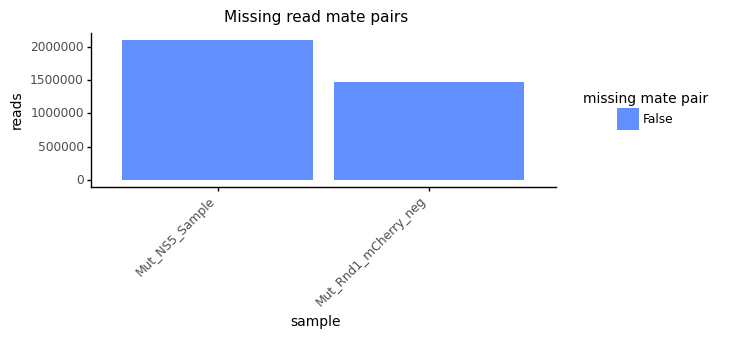

<ggplot: (8728578424661)>

In [14]:
mate_pair_qc = (p9.ggplot(results_pairs) +
              p9.aes(x='sample_name',
                     fill='missing_mate') +
              p9.geom_bar(stat='count') +
              p9.ggtitle('Missing read mate pairs') +
              p9.labs(x='sample',
                      y='reads',
                      fill='missing mate pair') +
              p9.theme(figure_size=(6, 2),
                       plot_title=p9.element_text(size=11),
                       axis_title=p9.element_text(size=10),
                       axis_text_x=p9.element_text(rotation=45, hjust=1),
                       legend_position='right',
                       legend_title=p9.element_text(size=10),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE_RICH[0:])
              )

display(mate_pair_qc)

Plot mismatched codon values from paired reads

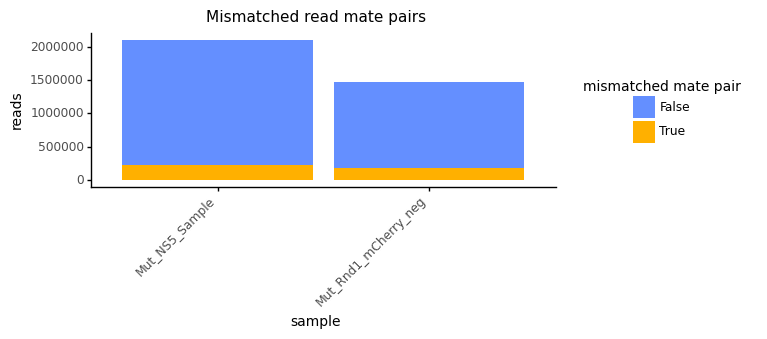

<ggplot: (8728389127921)>

In [15]:
mismatched_pairs_qc = (p9.ggplot(results_pairs) +
              p9.aes(x='sample_name',
                     fill='pair_mismatch') +
              p9.geom_bar(stat='count') +
              p9.ggtitle('Mismatched read mate pairs') +
              p9.labs(x='sample',
                      y='reads',
                      fill='mismatched mate pair') +
              p9.theme(figure_size=(6, 2),
                       plot_title=p9.element_text(size=11),
                       axis_title=p9.element_text(size=10),
                       axis_text_x=p9.element_text(rotation=45, hjust=1),
                       legend_position='right',
                       legend_title=p9.element_text(size=10),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE_RICH[0:])
              )

display(mismatched_pairs_qc)

## Filter data
Filter the data based on the QC metrics above.

In [16]:
results_filtered = (
    results_pairs
    .query(
        'missing_mate == False & '
        'pair_mismatch == False & '
        'R1 != "failed_parse" & '
        'R2 != "failed_parse"')
    [['sample_name', 'read_id', 'R1']]
    .rename(columns={'R1': 'codon'})
)

display(results_filtered)

read,sample_name,read_id,codon
0,Mut_NS5_Sample,M04866:509:000000000-JW58W:1:1101:10000:22059,CGC
1,Mut_NS5_Sample,M04866:509:000000000-JW58W:1:1101:10000:26661,CCT
2,Mut_NS5_Sample,M04866:509:000000000-JW58W:1:1101:10000:26942,ATG
3,Mut_NS5_Sample,M04866:509:000000000-JW58W:1:1101:10000:4907,CAC
4,Mut_NS5_Sample,M04866:509:000000000-JW58W:1:1101:10000:6247,CCT
...,...,...,...
3565294,Mut_Rnd1_mCherry_neg,M04866:509:000000000-JW58W:1:2114:9999:26548,GAT
3565295,Mut_Rnd1_mCherry_neg,M04866:509:000000000-JW58W:1:2114:9999:27495,GAG
3565296,Mut_Rnd1_mCherry_neg,M04866:509:000000000-JW58W:1:2114:9999:3148,ATT
3565297,Mut_Rnd1_mCherry_neg,M04866:509:000000000-JW58W:1:2114:9999:5715,GAC


## Plot codon frequencies

Label WT codons

In [17]:
results_filtered['wt'] = (results_filtered['codon'] == 'GAT')
display(results_filtered)

read,sample_name,read_id,codon,wt
0,Mut_NS5_Sample,M04866:509:000000000-JW58W:1:1101:10000:22059,CGC,False
1,Mut_NS5_Sample,M04866:509:000000000-JW58W:1:1101:10000:26661,CCT,False
2,Mut_NS5_Sample,M04866:509:000000000-JW58W:1:1101:10000:26942,ATG,False
3,Mut_NS5_Sample,M04866:509:000000000-JW58W:1:1101:10000:4907,CAC,False
4,Mut_NS5_Sample,M04866:509:000000000-JW58W:1:1101:10000:6247,CCT,False
...,...,...,...,...
3565294,Mut_Rnd1_mCherry_neg,M04866:509:000000000-JW58W:1:2114:9999:26548,GAT,True
3565295,Mut_Rnd1_mCherry_neg,M04866:509:000000000-JW58W:1:2114:9999:27495,GAG,False
3565296,Mut_Rnd1_mCherry_neg,M04866:509:000000000-JW58W:1:2114:9999:3148,ATT,False
3565297,Mut_Rnd1_mCherry_neg,M04866:509:000000000-JW58W:1:2114:9999:5715,GAC,False


WT vs mutant codons

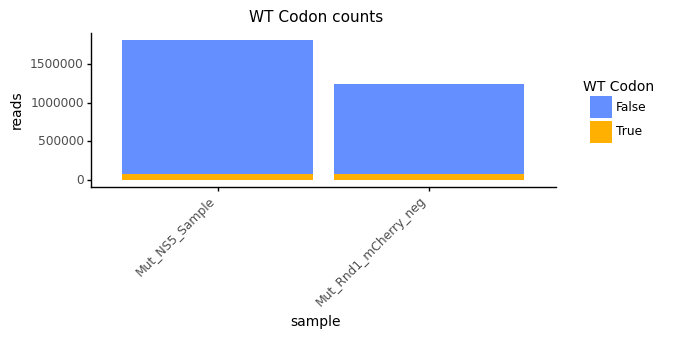

<ggplot: (8728390286861)>

In [18]:
wt_freq = (p9.ggplot(results_filtered) +
              p9.aes(x='sample_name',
                     fill='wt') +
              p9.geom_bar(stat='count') +
              p9.ggtitle('WT Codon counts') +
              p9.labs(x='sample',
                      y='reads',
                      fill='WT Codon') +
              p9.theme(figure_size=(6, 2),
                       plot_title=p9.element_text(size=11),
                       axis_title=p9.element_text(size=10),
                       axis_text_x=p9.element_text(rotation=45, hjust=1),
                       legend_position='right',
                       legend_title=p9.element_text(size=10),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE_RICH[0:])
              )

display(wt_freq)

## Count codons and calculate freuqencies

Count codons in each sample

In [19]:
codon_counts = (
    results_filtered
    .groupby(['sample_name'])
    ['codon']
    .value_counts()
    .reset_index(name='count')
)

counts_per_sample = (
    codon_counts
    .groupby('sample_name')
    ['count']
    .sum()
    .reset_index(name='sample_total')
)

codon_counts = pd.merge(
    left=codon_counts,
    right=counts_per_sample,
    on='sample_name',
    how='left',
    validate='many_to_one'
)

codon_counts['frequency'] = (
    codon_counts['count'] / codon_counts['sample_total']
)

display(codon_counts)

,sample_name,codon,count,sample_total,frequency
0,Mut_NS5_Sample,ATT,169080,1808248,0.093505
1,Mut_NS5_Sample,CGC,162366,1808248,0.089792
2,Mut_NS5_Sample,TAG,136769,1808248,0.075636
3,Mut_NS5_Sample,CCT,112566,1808248,0.062251
4,Mut_NS5_Sample,ATG,110051,1808248,0.060861
...,...,...,...,...,...
123,Mut_Rnd1_mCherry_neg,TAA,39,1247015,0.000031
124,Mut_Rnd1_mCherry_neg,CAA,35,1247015,0.000028
125,Mut_Rnd1_mCherry_neg,AAA,32,1247015,0.000026
126,Mut_Rnd1_mCherry_neg,CTA,8,1247015,0.000006


# Plot codon counts and frequencies per sample

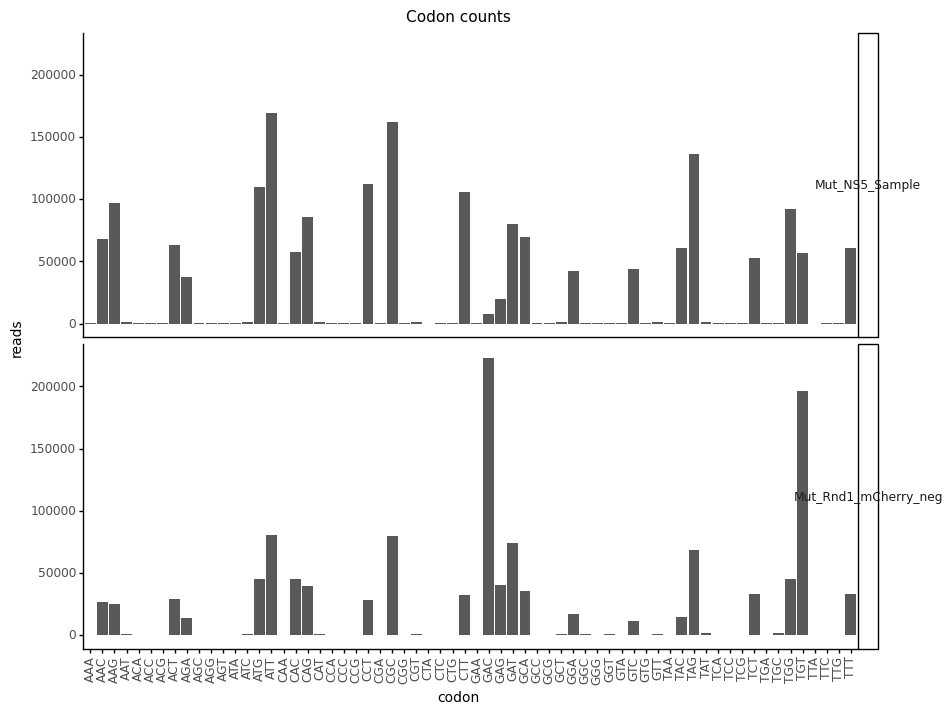

<ggplot: (8728388137638)>

In [20]:
codon_counts_plot = (p9.ggplot(codon_counts) +
                p9.aes(x='codon',
                       y='count') +
                p9.geom_bar(stat='identity') +
                p9.facet_grid('sample_name~') +
                p9.ggtitle('Codon counts') +
                p9.labs(x='codon',
                        y='reads') +
                p9.theme(figure_size=(10, 8),
                         plot_title=p9.element_text(size=11),
                         axis_title=p9.element_text(size=10),
                         axis_text_x=p9.element_text(rotation=90),
                         strip_text_y=p9.element_text(angle=0))
               )

display(codon_counts_plot)

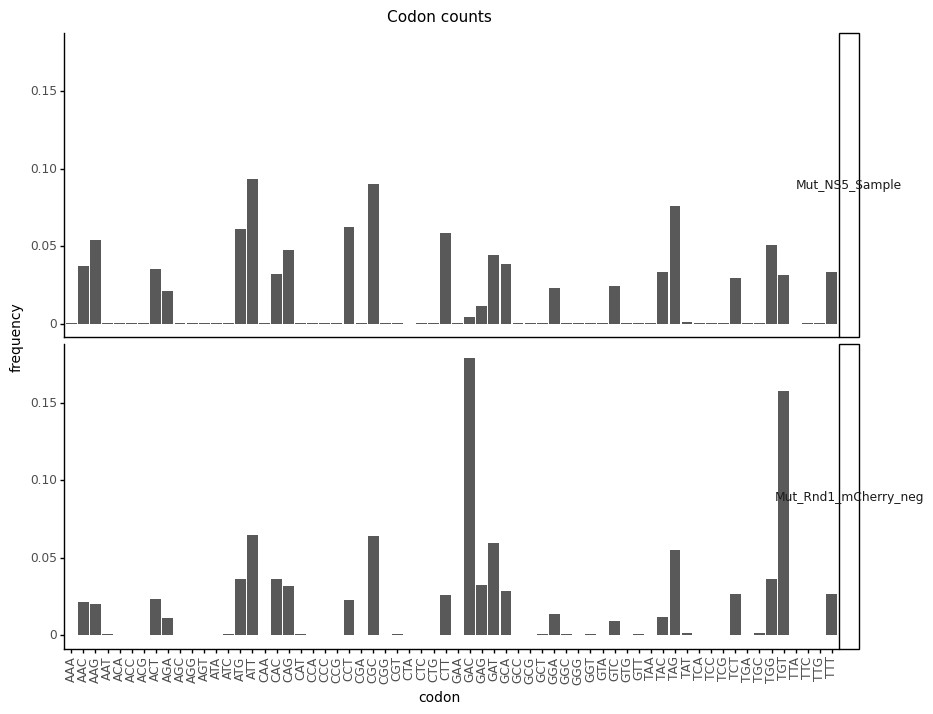

<ggplot: (8728386634009)>

In [21]:
codon_frequency_plot = (p9.ggplot(codon_counts) +
                p9.aes(x='codon',
                       y='frequency') +
                p9.geom_bar(stat='identity') +
                p9.facet_grid('sample_name~') +
                p9.ggtitle('Codon counts') +
                p9.labs(x='codon',
                        y='frequency') +
                p9.theme(figure_size=(10, 8),
                         plot_title=p9.element_text(size=11),
                         axis_title=p9.element_text(size=10),
                         axis_text_x=p9.element_text(rotation=90),
                         strip_text_y=p9.element_text(angle = 0))
               )

display(codon_frequency_plot)

## Calculate enrichment

Bring in experiment info

In [22]:
codon_counts_annotated = pd.merge(
    left=samples[['sample_name', 'infected', 'IFN']].drop_duplicates(),
    right=codon_counts[['sample_name', 'codon', 'frequency']],
    on='sample_name',
    how='right',
    validate='one_to_many'
)

display(codon_counts_annotated)

,sample_name,infected,IFN,codon,frequency
0,Mut_NS5_Sample,True,None,ATT,0.093505
1,Mut_NS5_Sample,True,None,CGC,0.089792
2,Mut_NS5_Sample,True,None,TAG,0.075636
3,Mut_NS5_Sample,True,None,CCT,0.062251
4,Mut_NS5_Sample,True,None,ATG,0.060861
...,...,...,...,...,...
123,Mut_Rnd1_mCherry_neg,True,False,TAA,0.000031
124,Mut_Rnd1_mCherry_neg,True,False,CAA,0.000028
125,Mut_Rnd1_mCherry_neg,True,False,AAA,0.000026
126,Mut_Rnd1_mCherry_neg,True,False,CTA,0.000006


Define enrichment

```Enrichment = log2(frequency in selected condition / frequency in reference condition)```

In [26]:
def calculate_enrichment(selected_sample, reference_sample):
    selected_freqs = (codon_counts
                      .query(f'sample_name == "{selected_sample}"')
                      [['codon', 'frequency']])
    reference_freqs = (codon_counts
                       .query(f'sample_name == "{reference_sample}"')
                       [['codon', 'frequency']])
    enrichment_df = pd.merge(
        left=reference_freqs,
        right=selected_freqs,
        on=['codon'],
        how='left',
        validate='one_to_one')
    enrichment_df.columns = ['codon', 'reference_frequency', 'selected_frequency']
    enrichment_df['enrichment'] = (
        np.log2(enrichment_df['selected_frequency'] / 
                enrichment_df['reference_frequency']))
    return(enrichment_df)

,codon,reference_frequency,selected_frequency,enrichment
0,ATT,0.093505,0.064330,-0.539558
1,CGC,0.089792,0.063735,-0.494508
2,TAG,0.075636,0.054712,-0.467213
3,CCT,0.062251,0.022619,-1.460583
4,ATG,0.060861,0.035912,-0.761035
...,...,...,...,...
59,TAA,0.000062,0.000031,-0.985839
60,CCA,0.000059,0.000037,-0.681791
61,CCG,0.000038,0.000033,-0.214859
62,CTA,0.000014,0.000006,-1.107742


Plot IFN agonist population (NS5+, IFN-)

In [ ]:
IFN_agonist_enrichment = calculate_enrichment("Mut_Rnd1_mCherry_neg","Mut_NS5_Sample")
display(IFN_agonist_enrichment)

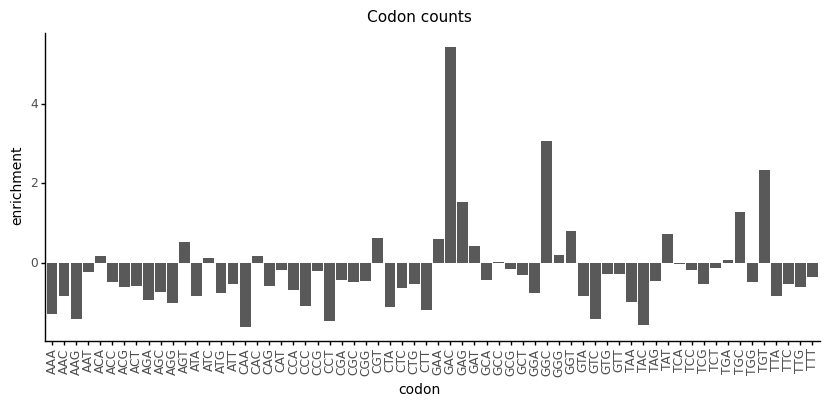

<ggplot: (8728384995708)>

In [27]:
IFN_agonist_plot = (p9.ggplot(IFN_agonist_enrichment) +
                p9.aes(x='codon',
                       y='enrichment') +
                p9.geom_bar(stat='identity') +
                p9.ggtitle('Codon counts') +
                p9.labs(x='codon',
                        y='enrichment') +
                p9.theme(figure_size=(10, 4),
                         plot_title=p9.element_text(size=11),
                         axis_title=p9.element_text(size=10),
                         axis_text_x=p9.element_text(rotation=90),
                         strip_text_y=p9.element_text(angle = 0))
               )

display(IFN_agonist_plot)

Plot **FAILED** IFN agonist population (NS5+, IFN+)

In [ ]:
IFN_agonist_enrichment = calculate_enrichment("Mut_Rnd1_mCherry_pos","Mut_NS5_Sample")
display(IFN_agonist_enrichment)

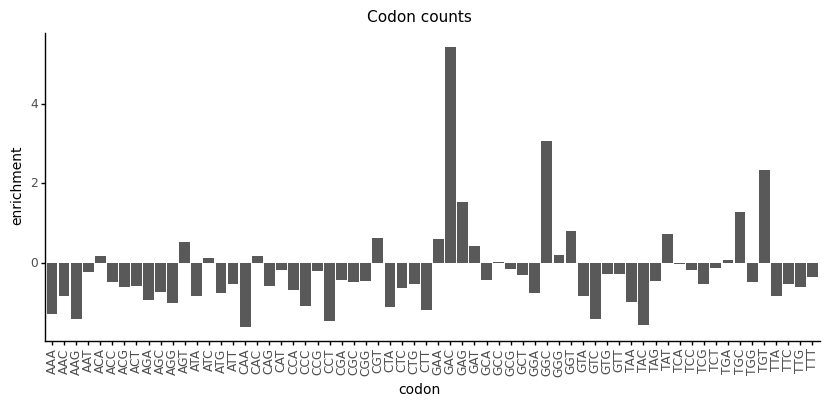

<ggplot: (8728384995708)>

In [27]:
IFN_agonist_plot = (p9.ggplot(IFN_agonist_enrichment) +
                p9.aes(x='codon',
                       y='enrichment') +
                p9.geom_bar(stat='identity') +
                p9.ggtitle('Codon counts') +
                p9.labs(x='codon',
                        y='enrichment') +
                p9.theme(figure_size=(10, 4),
                         plot_title=p9.element_text(size=11),
                         axis_title=p9.element_text(size=10),
                         axis_text_x=p9.element_text(rotation=90),
                         strip_text_y=p9.element_text(angle = 0))
               )

display(IFN_agonist_plot)